## AirBnB Prices in Edinburgh - Cleaning and Models

### Setup

In [114]:
# Imports

# General
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import ast
from collections import Counter
import warnings
import seaborn as sns
import re

# Models
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Feature Engineering
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, r_regression
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.decomposition import PCA

# Misc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ttest_ind
from scipy import stats

# Settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [134]:
# Read in the data frame
df = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/listings.csv.gz')

### Data Inspection

* Inspection of:
    * columns and information about data frame including types.
    * missing values present.
    * correlated variables within the dataframe.

In [116]:
# Lots of columns (like id, listing_url, and scrape_id) do not look useful for our models. These can be dropped
display(df)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,15420,https://www.airbnb.com/rooms/15420,20221216161317,2022-12-16,city scrape,Georgian Boutique Apt City Centre,"Stunning, spacious ground floor apartment minu...","The neighbourhood is in the historic New Town,...",https://a0.muscache.com/pictures/cf69631f-4194...,60423,https://www.airbnb.com/users/show/60423,Charlotte,2009-12-06,"Edinburgh, United Kingdom","I have a background in property, having worked...",within a few hours,100%,96%,t,https://a0.muscache.com/im/users/60423/profile...,https://a0.muscache.com/im/users/60423/profile...,NaN,3,6,"['email', 'phone']",t,t,"Edinburgh, City of Edinburgh, United Kingdom","Old Town, Princes Street and Leith Street",NaN,55.95759,-3.18805,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Self check-in"", ""Hot water kettle"", ""Private...",$114.00,3,30,1,3,30,30,3.0,30.0,NaN,t,5,22,35,187,2022-12-16,450,73,4,2011-01-18,2022-11-29,4.97,4.98,4.96,4.97,4.98,4.98,4.91,NaN,f,1,1,0,0,3.10
1,707097,https://www.airbnb.com/rooms/707097,20221216161317,2022-12-16,city scrape,Centre Royal Mile Apartment 3 bedrooms 2 bathr...,NaN,"The location is the perfect for tourism , shor...",https://a0.muscache.com/pictures/6e2ded8d-f20b...,3092851,https://www.airbnb.com/users/show/3092851,Lynne,2012-07-29,"Edinburgh, United Kingdom",Airbnb partner owner . Will do my best to make...,within a day,50%,84%,f,https://a0.muscache.com/im/pictures/user/7a078...,https://a0.muscache.com/im/pictures/user/7a078...,Old Town,9,16,"['email', 'phone']",t,t,"Edinburgh, United Kingdom","Old Town, Princes Street and Leith Street",NaN,55.94980,-3.18354,Entire condo,Entire home/apt,9,NaN,2 baths,3.0,7.0,"[""TV with standard cable"", ""Stove"", ""Self chec...",$598.00,2,1000,28,300,1125,1125,104.3,1125.0,NaN,t,0,4,4,210,2022-12-16,67,7,0,2013-01-03,2022-09-22,4.38,4.32,4.40,4.69,4.72,4.94,4.09,NaN,t,8,6,2,0,0.55
2,728199,https://www.airbnb.com/rooms/728199,20221216161317,2022-12-16,city scrape,"Private room in central, spacious and comfy flat",Fantastic main door flat over two levels withi...,"Great location for access to the city centre, ...",https://a0.muscache.com/pictures/11315577/0091...,3776412,https://www.airbnb.com/users/show/3776412,Tom,2012-10-06,"Edinburgh, United Kingdom",We are an early/mid 40's couple who love to tr...,within an hour,100%,95%,t,https://a0.muscache.com/im/pictures/user/5e480...,https://a0.muscache.com/im/pictures/user/5e480...,NaN,1,2,"['email', 'phone']",t,t,"Edinburgh, United Kingdom",Polwarth,NaN,55.93692,-3.22414,Private room in rental unit,Private room,3,NaN,1 private bath,1.0,1.0,"[""Self check-in"", ""Stove"", ""Bed linens"", ""Chil...",$60.00,1,14,1,4,14,14,1.3,14.0,NaN,t,6,24,49,

In [117]:
# Columns including bathrooms_text, host_response_rate,
# host_acceptance_rate, and price are all strings. These should
# be converted to integers/floats so they can be used in models accurately.

# host_is_superhost, host_identity_verified, has_availability, instant_bookable,
# host_has_profile_pic, host_response_time, host_verifications are all strings but
# could be converted to integer values for true and false or ordinal values 
# for host_response_time and host_verifications.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7389 entries, 0 to 7388
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            7389 non-null   int64  
 1   listing_url                                   7389 non-null   object 
 2   scrape_id                                     7389 non-null   int64  
 3   last_scraped                                  7389 non-null   object 
 4   source                                        7389 non-null   object 
 5   name                                          7389 non-null   object 
 6   description                                   7318 non-null   object 
 7   neighborhood_overview                         5184 non-null   object 
 8   picture_url                                   7389 non-null   object 
 9   host_id                                       7389 non-null   i

<Axes: >

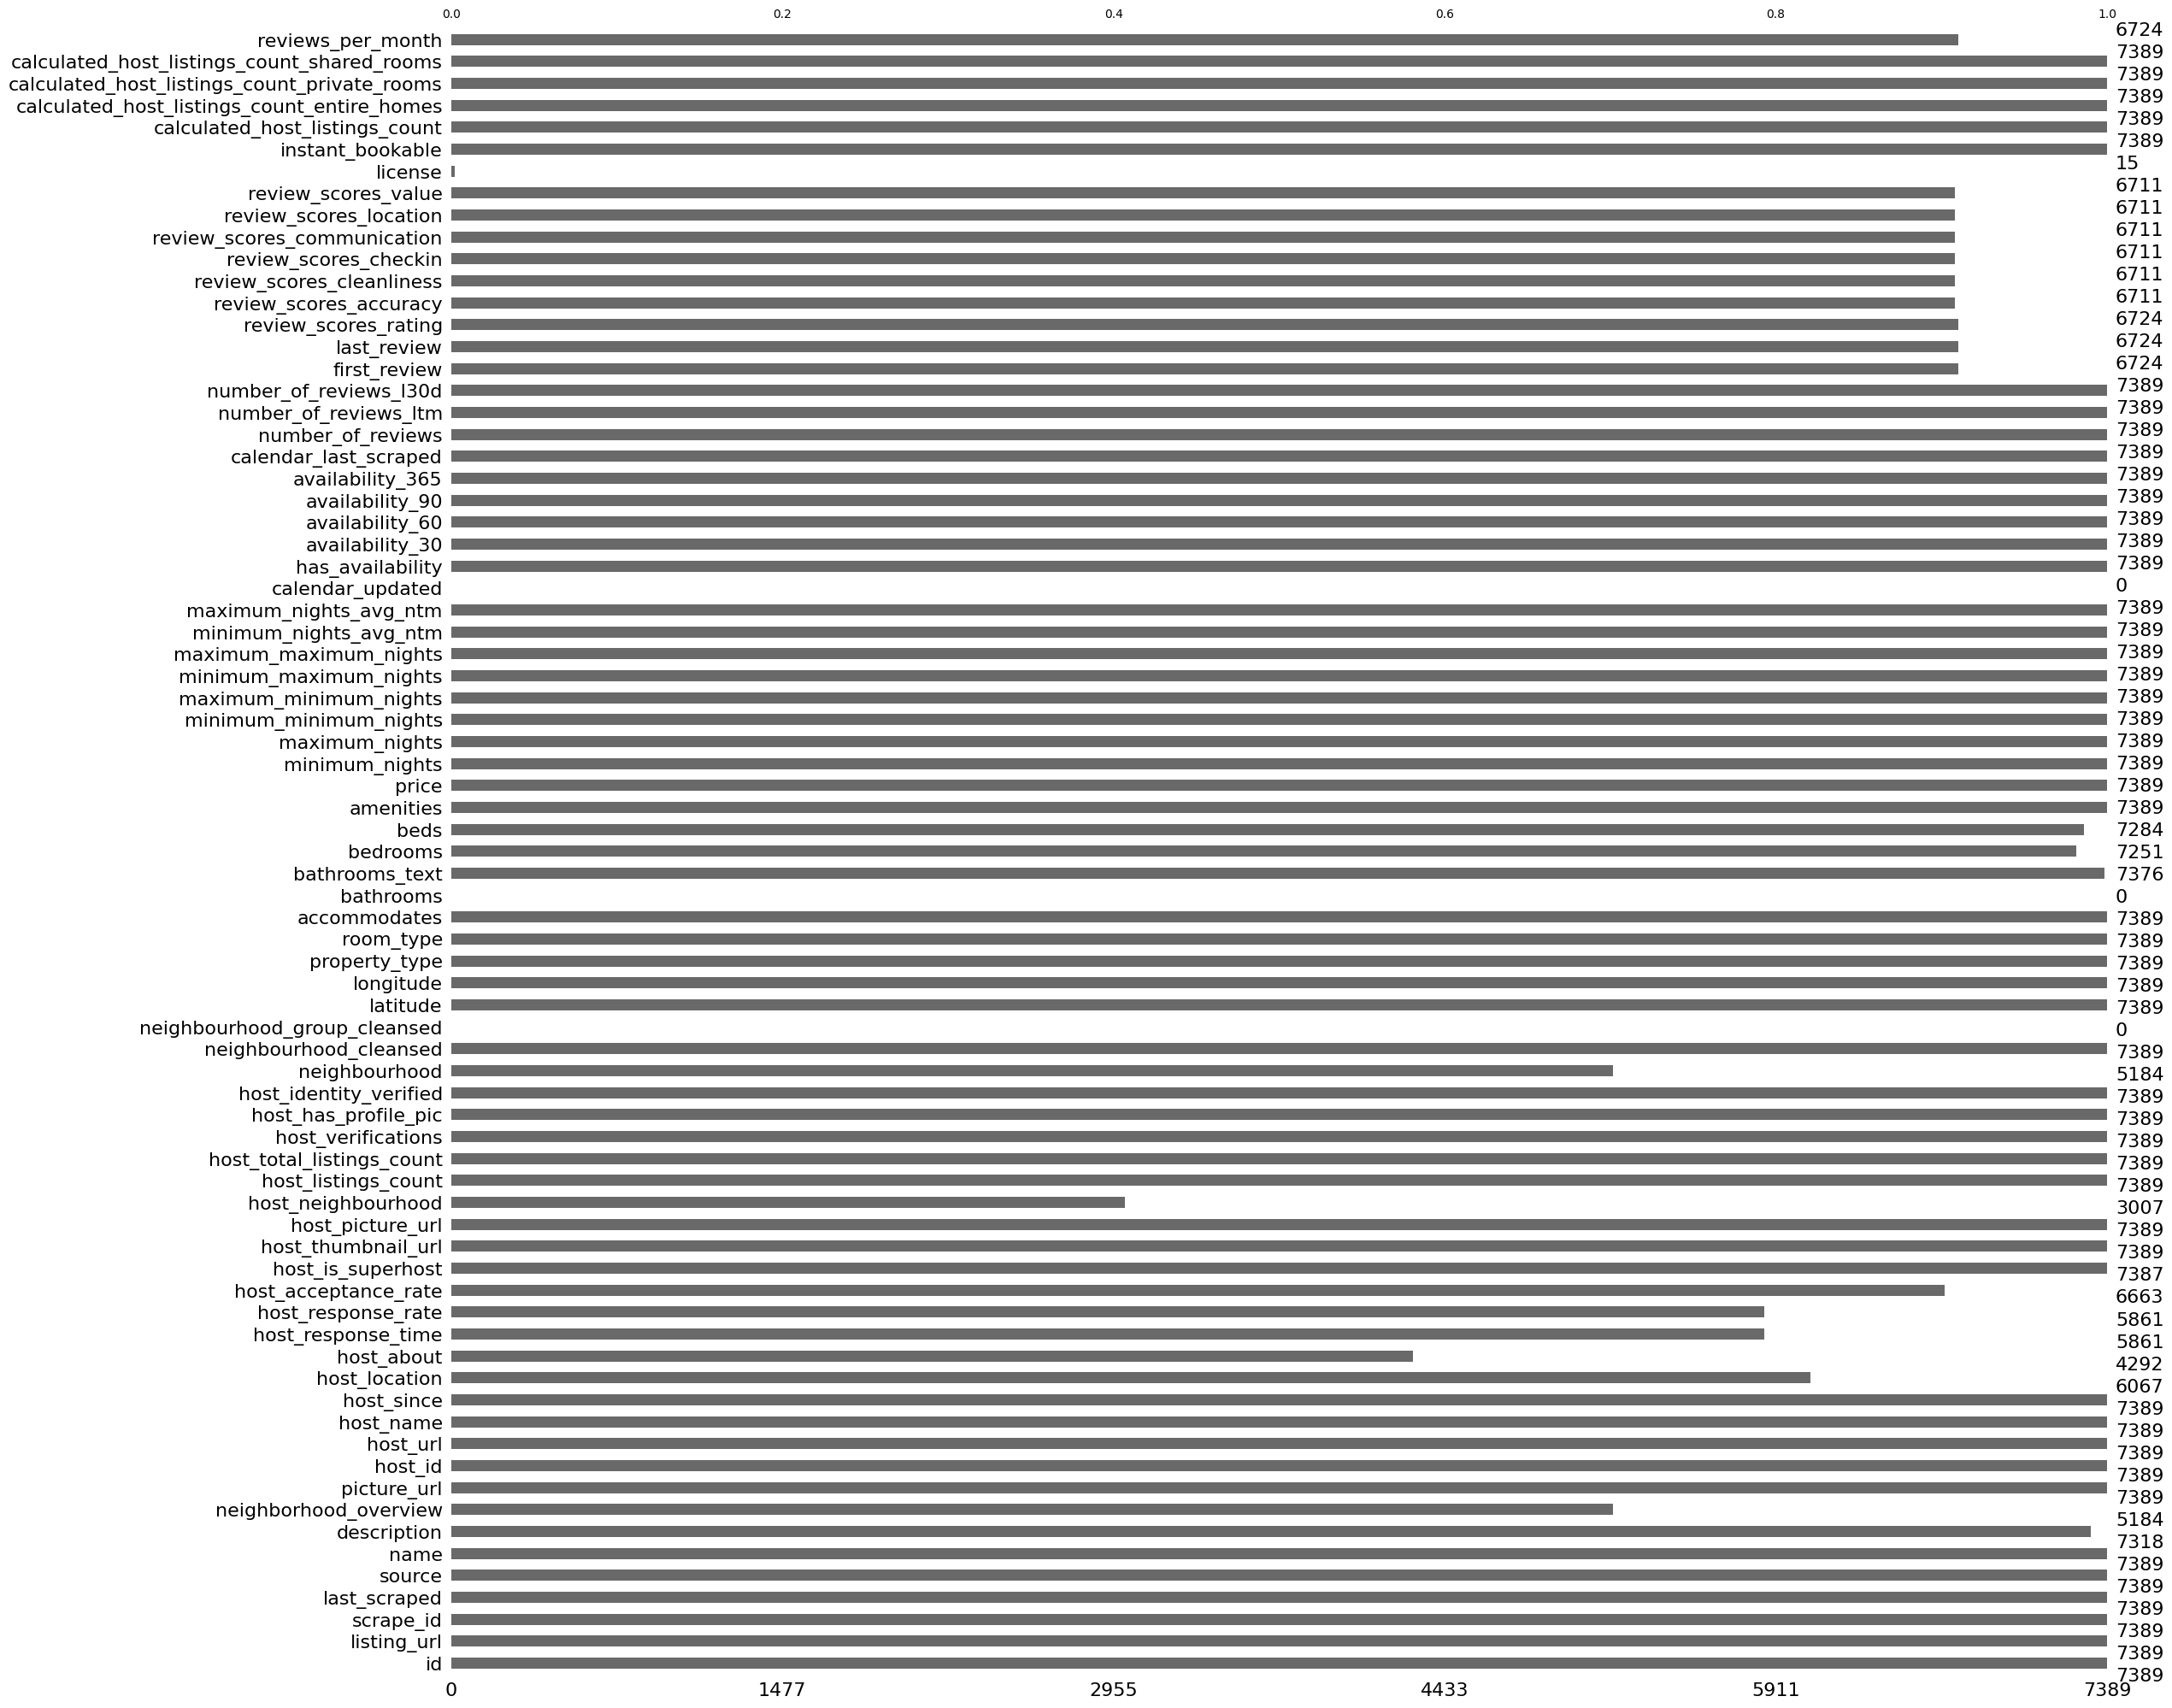

In [118]:
# Columns with large numbers of missing values can be dropped
msno.bar(df)

In [119]:
# These values can be one-hot-encoded (although maybe not all).
df['property_type'].unique()

array(['Entire rental unit', 'Entire condo',
       'Private room in rental unit', 'Private room in bed and breakfast',
       'Private room in townhouse', 'Private room in home', 'Entire loft',
       'Entire guest suite', 'Entire home', 'Private room in condo',
       'Private room in guest suite', 'Entire townhouse',
       'Entire cottage', 'Private room in bungalow', 'Entire bungalow',
       'Entire guesthouse', 'Shared room in hostel', 'Campsite',
       'Room in hostel', 'Entire villa', 'Room in hotel',
       'Entire serviced apartment', 'Room in serviced apartment',
       'Private room in cottage', 'Private room in villa',
       'Entire chalet', 'Private room in guesthouse',
       'Private room in loft', 'Room in aparthotel', 'Private room',
       'Tiny home', 'Private room in tiny home', 'Entire place',
       'Entire cabin', 'Room in boutique hotel',
       'Shared room in rental unit', 'Camper/RV', 'Barn', 'Windmill',
       'Private room in hostel', 'Boat', 'Hut',
   

In [120]:
# These values can be one-hot-encoded
df['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [121]:
# Regex will have to be applied before one-hot-encoding
df['amenities'][0]

'["Self check-in", "Hot water kettle", "Private entrance", "Bed linens", "Children\\u2019s dinnerware", "Clothing storage", "Drying rack for clothing", "Kitchen", "Microwave", "Body soap", "Bathtub", "Sound system", "Carbon monoxide alarm", "Long term stays allowed", "Free dryer \\u2013 In unit", "Iron", "Wifi", "Cooking basics", "Essentials", "Freezer", "Shower gel", "Refrigerator", "Hot water", "High chair", "Dishwasher", "Lockbox", "Garden view", "Baking sheet", "Heating", "Courtyard view", "Crib", "Smoke alarm", "Dining table", "Extra pillows and blankets", "Toaster", "Single level home", "Hair dryer", "Room-darkening shades", "Oven", "Cleaning products", "Conditioner", "Shampoo", "Coffee maker: Nespresso", "Hangers", "Dishes and silverware", "Pack \\u2019n play/Travel crib", "TV", "Wine glasses", "Luggage dropoff allowed", "Indoor fireplace", "Paid parking off premises", "Fire extinguisher", "Free washer \\u2013 In unit", "First aid kit"]'

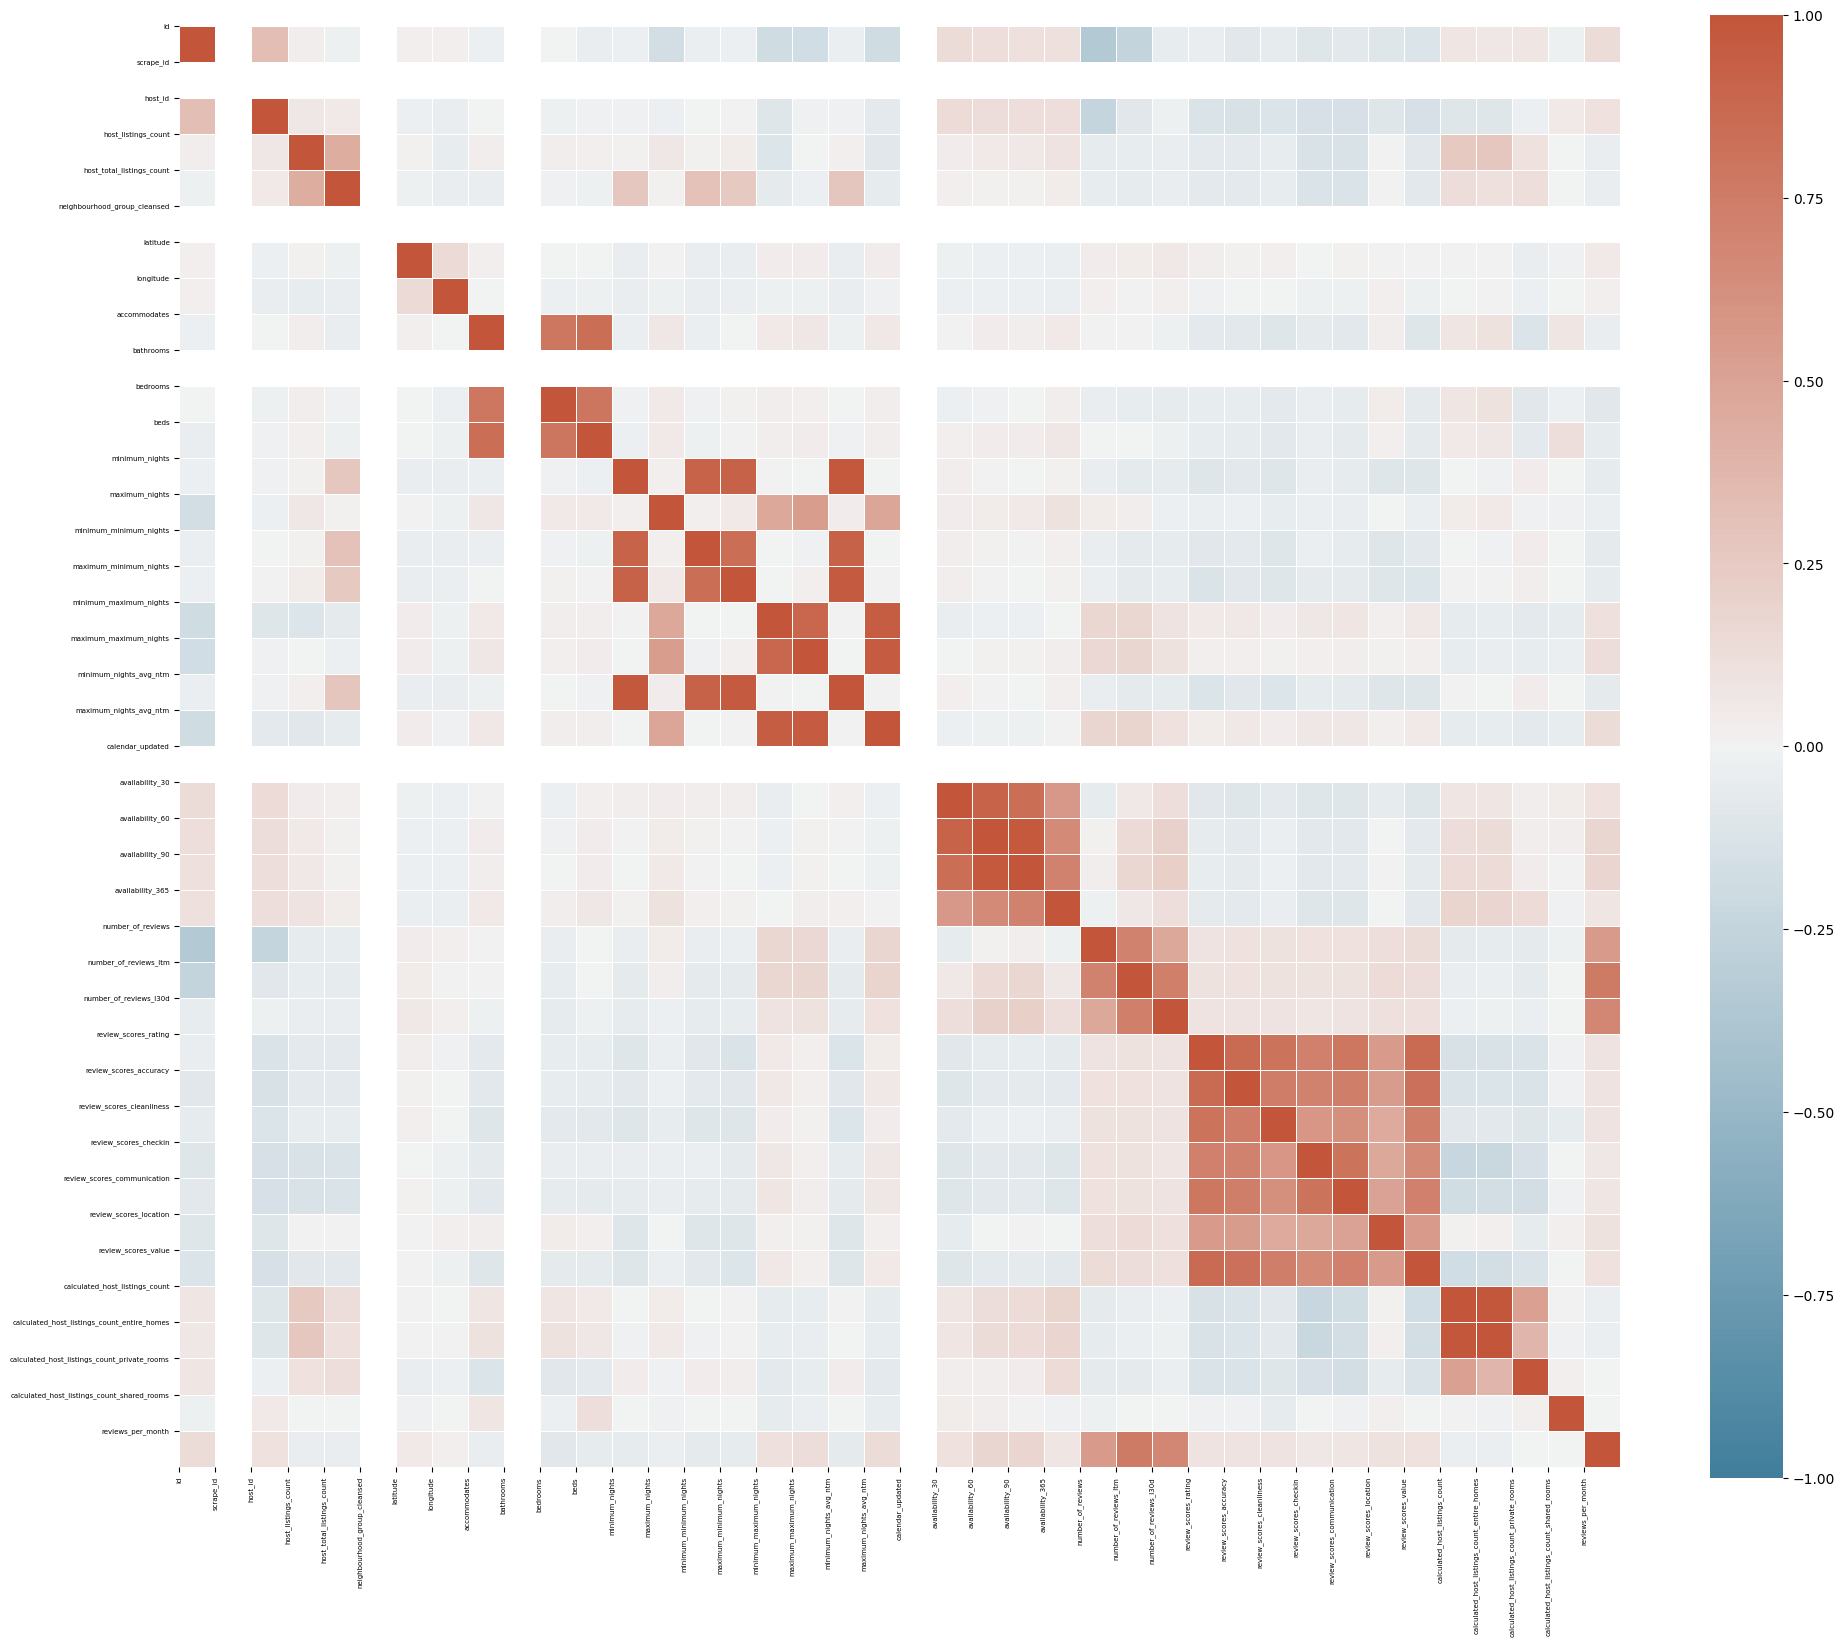

In [122]:
# PCA could be used on highly correlated values

# Calculate the correlation matrix
corr = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with annotations and correct aspect ratio
sns.heatmap(corr, cmap=cmap, annot=False, fmt='.2f', center=0, square=True, linewidths=.5, cbar_kws={"shrink": 0.75}, vmin=-1, vmax=1, annot_kws={"fontsize": 15})

# Force all column names to show
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90, fontsize=5)
ax.set_yticklabels(corr.columns, rotation=0, fontsize=5)

# Adjust the subplot layout to avoid cutoff of labels
plt.tight_layout()

# Show the plot
plt.show()


#### Conclusions

* Lots of columns can be dropped
* Lots of values can have types converted to have more meaning
* Categorical values can be one-hot-encoded
* The dimensionality of the dataframe can be reduced using PCA

### Clean Data

A pipeline is used to process and clean the data

Dropping Columns

In [123]:
def drop_columns(df):
    df.drop(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'bathrooms', 'calendar_updated', 'calendar_last_scraped', 'first_review', 'last_review', 'license'], axis=1, inplace=True)

    return df

Converting Data to Numeric Types

In [124]:
def convert_to_numeric(df):
    # Convert bathrooms to numeric
    df['bathrooms_text'] = df['bathrooms_text'].str.extract(r'([\d.]+)').astype('float')

    # Change percentages to be numeric
    df['host_response_rate'] = df['host_response_rate'].str.replace("%", "")
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace("%", "")
    
    # Converting price to float
    df['price'] = df['price'].str.replace("$", "")
    df['price'] = df['price'].str.replace(",", "")
    df['price'] = df['price'].astype(float)
    
    return df

Dropping Values

In [125]:
def drop_values(df):
    # Drop values not greater than 0
    df = df[df.bedrooms > 0]
    df = df[df.accommodates > 0]
    df = df[df.beds > 0]
    df = df[df.accommodates > 0]
    df = df[df.number_of_reviews > 5]

    # Dropping prices not greater than 0
    df = df[df.price > 0]
    
    # Quartiles by the Empirical Rule
    quantiles = df['price'].quantile([0.025, 0.975])
    low = quantiles[0.025]
    high = quantiles[0.975]

    # Remove outliers in the dataframe to include only two standard deviations
    df = df[(df['price'] >= low) & (df['price'] <= high)]

    df.dropna(inplace=True)
    return df

Transforming Numeric Values

In [126]:
def numeric_transforms(df):
    # Convert response and acceptance rate to a percentage
    df['host_response_rate'] = df['host_response_rate'].astype(float) / 100.0
    df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(float) / 100.0

    # Normalise price to scale the data
    df['price'] = np.log10(df['price'])

    return df

Encoding Values

In [127]:
def map(df):

    # Map f and t to 0 and 1 respectively so that true false values can be included in the model
    mapping = {'f': 0, 't': 1}

    df['host_is_superhost'] = df["host_is_superhost"].map(mapping)
    df['host_identity_verified'] = df["host_identity_verified"].map(mapping)
    df['has_availability'] = df["has_availability"].map(mapping)
    df['instant_bookable'] = df["instant_bookable"].map(mapping)
    df['host_has_profile_pic'] = df["host_has_profile_pic"].map(mapping)

    # Ordinally encode values
    df['host_response_time'] = df["host_response_time"].map({'within an hour': 4, 'within a few hours': 3, 'within a day': 2, 'a few days or more': 1})
    df['host_verifications'] = df['host_verifications'].apply(lambda row: len(ast.literal_eval(row))) # More ways to contact the better
    return df

One-Hot-Encoding for Room Type

In [128]:
def one_hot_room(df):
    # Reset index for concatenation
    df.reset_index(drop=True, inplace=True)

    # One-Hot-Encoding of room_type
    column_to_encode = 'room_type'
    encoder = OneHotEncoder(sparse=False)
    encoded_columns = encoder.fit_transform(df[[column_to_encode]])

    # Dataframe creation
    encoded_column_names = encoder.get_feature_names_out([column_to_encode])
    encoded_df = pd.DataFrame(encoded_columns, columns=encoded_column_names)

    # Drop original column and concatenate
    df.drop(column_to_encode, axis=1, inplace=True)
    df = pd.concat([df, encoded_df], axis=1)

    return df

One-Hot-Encoding for Property Type

In [129]:
def one_hot_property(df):

    column_to_encode = 'property_type'

    # Take first word
    df[column_to_encode] = df[column_to_encode].str.split().str[0]

    # Mapping dictionary gto store as
    mapped_dict = {"Entire": "Entire","Private": "Private","Shared": "Shared", "Room": "Room"}

    # Apply to dataframe
    df[column_to_encode] = df[column_to_encode].apply(lambda row: mapped_dict.get(row, 'Other'))

    # One-Hot-Encoding of property_type
    
    encoder = OneHotEncoder(sparse=False)
    encoded_columns = encoder.fit_transform(df[[column_to_encode]])

    # Dataframe creation
    encoded_column_names = encoder.get_feature_names_out([column_to_encode])
    encoded_df = pd.DataFrame(encoded_columns, columns=encoded_column_names)

    # Drop original column and concatenate
    df.drop(column_to_encode, axis=1, inplace=True)
    df = pd.concat([df, encoded_df], axis=1)

    return df

One-Hot-Encoding Amenities

Regex

In [130]:
def regex_amenities(df):
    
    # Convert amenities from string to list
    df['amenities'] = df['amenities'].apply(lambda row: ast.literal_eval(row))

    # Common phrase map
    common_phrases = {
        'tv': 'TV',
        'oven': 'Oven',
        'stove': 'Stove',
        'soap': 'Soap',
        'conditioner': 'Soap',
        'shampoo': 'Soap',
        'parking': 'Parking',
        'view': 'View',
        'coffee': 'Coffee Facilities',
        'wifi': 'WiFi',
        'backyard': 'Backyard',
        'washer': 'Washer',
        'toys': 'Toys',
        'console': 'Console',
        'clothing storage': 'Clothing Storage',
        'dryer': 'Dryer',
        'hair dryer': 'Dryer'
    }

    # Map phrases to common values to reduce amenities list and standardise values
    pattern = re.compile("|".join(f"\\b{key}\\b" for key in common_phrases.keys()), re.IGNORECASE)

    def map_common_phrases(amenities):
        return [common_phrases.get(item.lower(), item) for item in amenities if item]

    df['amenities'] = df['amenities'].apply(map_common_phrases)
    return df

Filtering Amenities Column

In [131]:
def filter_amenities(df):
    array = df['amenities'].to_list()

    # Reduce dimensions from 2D to 1D
    flattened_array = [element for sublist in array for element in sublist]
    counter = Counter(flattened_array)


    # Create a filtered list so that less relevant amenities can be removed from the dataset (change number to change amenities listings)
    filtered_items = [item for item, count in counter.items() if count >= 400]

    # Filter based on selection
    df['amenities'] = df['amenities'].apply(lambda row: [item for item in row if item in filtered_items])

    return df

One-Hot-Encoding of Remaining Amenities

In [132]:
def one_hot_amenities(df):

    # Multi Label Binariser for encoding
    mlb = MultiLabelBinarizer(sparse_output=False)

    # Binarises, drops amenities, and joins with binarised variables
    df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('amenities')),
                            columns=mlb.classes_,
                            index=df.index))
    
    return df

Compression using PCA

In [133]:
def data_compression(df, name, start, finish):
    columns_between = df.loc[:, start:finish]

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(columns_between)

    # Perform PCA
    pca = PCA(n_components=1)  # Set n_components to 1 for PC1
    compressed_data = pca.fit_transform(scaled_data)

    compressed_df = pd.DataFrame(data=compressed_data, columns=[name])
    
    # Replace columns with PC1
    # Drop the original columns for PCA from the DataFrame
    df.drop(columns=list(columns_between.columns), inplace=True)

    # Concatenate the compressed data with the rest of the DataFrame
    df = pd.concat([df, compressed_df], axis=1)

    return df


### Pipeline

In [135]:
# Read in data
# data = df.pipe(drop_columns).pipe(convert_to_numeric).pipe(numeric_transforms).pipe(drop_values).pipe(map).pipe(one_hot_room).pipe(one_hot_property).pipe(regex_amenities).pipe(filter_amenities).pipe(one_hot_amenities).pipe(data_compression, 'reviews_pc1', 'review_scores_rating', 'review_scores_value').pipe(data_compression, 'availability_pc1', 'availability_30', 'availability_365').pipe(data_compression, 'nights_pc1', 'minimum_nights', 'maximum_nights_avg_ntm')

data = (
    df.pipe(drop_columns)
      .pipe(convert_to_numeric)
      .pipe(apply_numeric_transforms)
      .pipe(drop_specific_values)
      .pipe(apply_value_mapping)
      .pipe(one_hot_encode_rooms)
      .pipe(one_hot_encode_properties)
      .pipe(apply_amenities_regex)
      .pipe(filter_amenities)
      .pipe(one_hot_encode_amenities)
      .pipe(compress_data, 'reviews_pc1', 'review_scores_rating', 'review_scores_value')
      .pipe(compress_data, 'availability_pc1', 'availability_30', 'availability_365')
      .pipe(compress_data, 'nights_pc1', 'minimum_nights', 'maximum_nights_avg_ntm')
)

display(data)

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,accommodates,bathrooms_text,bedrooms,beds,price,has_availability,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,property_type_Entire,property_type_Other,property_type_Private,property_type_Room,property_type_Shared,Backyard,Baking sheet,Bathtub,Bed linens,Board games,Body soap,Books and reading material,Carbon monoxide alarm,Central heating,Cleaning products,Clothing storage: closet,Coffee Facilities,Coffee maker,Cooking basics,Crib,Dedicated workspace,Dining table,Dishes and silverware,Dishwasher,Dryer,Drying rack for clothing,Elevator,Essentials,Ethernet connection,Extra pillows and blankets,Fire extinguisher,First aid kit,Free parking on premises,Free street parking,Free washer – In unit,Freezer,Hangers,Heating,High chair,Host greets you,Hot water,Hot water kettle,Indoor fireplace,Iron,Kitchen,Laundromat nearby,Lockbox,Long term stays allowed,Luggage dropoff allowed,Microwave,Outdoor furniture,Oven,Pack ’n play/Travel crib,Paid parking off premises,Pets allowed,Private entrance,Refrigerator,Room-darkening shades,Self check-in,Shower gel,Single level home,Smoke alarm,Soap,Stove,TV,Toaster,Washer,WiFi,Wine glasses,reviews_pc1,availability_pc1,nights_pc1
0,3,1.0,0.96,1,3,6,2,1,1,2,1.0,1.0,1.0,2.056905,1,450,73,4,0,1,1,0,0,3.10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,1,1,0,1,0,1,0,1,0,0,0,1,1,0,1,1,1,1,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,0,1,1,-2.006715,-0.452082,-2.119678
1,4,1.0,0.95,1,1,2,2,1,1,3,1.0,1.0,1.0,1.778151,1,354,52,2,0,1,0,1,0,2.86,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,1,0,1,1,1,0,1,1,0,0,1,1,0,0,1,1,1,1,0,1,0,1,1,0,1,0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,1,0,0,0,1,1,1,1,0,1,1,1,0,0,1,0,0,-0.554122,-0.039380,-2.397367
2,4,1.0,0.99,0,6,9,2,1,1,10,2.0,4.0,8.0,2.209515,1,268,51,4,1,2,2,0,0,2.27,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,1,1,1,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,1,1,1,0,1,0,0,1,0,1,0,0,0,1,1,1,0,1,0,1,1,0,0.510079,-0.928710,-1.511447
3,4,1.0,1.00,1,1,1,2,1,1,4,1.0,2.0,2.0,2.139879,1,210,7,0,1,1,1,0,0,1.73,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,-1.671824,-1.118979,-2.144620
4,4,1.0,0.91,0,2,2,3,1,1,6,1.5,3.0,4.0,1.995635,1,49,13,0,1,1,1,0,0,0.48,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,1,1,1,1,1,0,1,0,0,1,0,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,1,4.039864,-2.738153,0.439138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4269,3,1.0,0.77,1,1,2,2,1,1,2,2.0,1.0,2.0,1.845098,1,80,19,1,0,1,0,1,0,0.62,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,1,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,1,1,0,0,1,0,0,1,1,0,0,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,0,1,0,0,1,1,0,1,0,1,1,0,0,1,0,1,1,-1.744849,1.669585,-1.925751
4270,3,1.0,1.00,0,6,7,2,1,1,2,1.0,1.0,4.0,1.977724,1,41,0,0,0,4,3,1,0,0.33,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1.283361,-2.738153,-2.285294
4271,4,1.0,0.25,0,1,2,2,1,1,2,2.5,1.0,1.0,1.602060,1,68,

### Testing Models - All the Data

In this section, which model to use for feature selection on is tested

In [137]:
def model_test(model, X, y):
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    model.fit(X_train, y_train)

    # Get coefficients/importances
    if isinstance(model, LinearRegression):
        coefficients = model.coef_
    else: 
        coefficients = model.feature_importances_

    # Display coefficients/importances
    coef = pd.DataFrame({'Feature': X.columns, 'Importance': coefficients}).sort_values(by='Importance', ascending=False)
    display(coef)

    # Predict values
    y_pred = model.predict(X_test)

    # Print root mean square error
    rmse = mean_squared_error(y_test, y_pred) ** (1/2)
    print('RMSE (average error per prediction):', rmse)

    # Print r^2
    score = model.score(X_test, y_test)
    print("R-squared score (accuracy):", score)
    
    return model, coef

In [138]:
# Target variable and features
X = data.drop(['price'], axis=1)
y = data['price']

##### Multiple Regression
Advantages:
* By far the simplest model <br>
* Allows for the modeling of complex relationships between the dependent variable and multiple independent variables 
* Allows for the control of the effects of confounding variables on the relationship between features and the target variable 
* Can be used to test hypotheses about relationships between features and the target variable 

Disadvantages:
* Including too many features (as we have) in the model can lead to overfitting 
* If two or more features are highly correlated, it can be difficult to estimate their individual effects on and relationstips to the target variable. As we have a lot of correlated features this could be an issue 
* Multiple regression assumes that the relationship between features and target variables is linear, that errors are normally distributed, and that there is similar variance across columns 
* Outliers in the data can have a significant impact on results 
* Multiple regression requires incredibly high-quality data 

In [139]:
lin_reg = LinearRegression()
linear_regression, lr_coef = model_test(lin_reg, X, y)

,Feature,Importance
23,room_type_Entire home/apt,0.220441
30,property_type_Room,0.159098
11,bedrooms,0.073948
25,room_type_Private room,0.045629
10,bathrooms_text,0.039799
...,...,...
1,host_response_rate,-0.041380
60,Free street parking,-0.067406
24,room_type_Hotel room,-0.113184
31,property_type_Shared,-0.152886


RMSE (average error per prediction): 0.13811205026159837
R-squared score (accuracy): 0.6410571571716661


##### Random Forest Model
Advantages:
* Easily deals with non-linear relationships between features and the target variable <br>
* Can deal with larger datasets with many features (we have a dataset with many features while not being that large) 
* Does not data to be normalised
* Easily handles any missing data that may have slipped through
* Provides values for the importance of each feature

Disadvantages:
* Prone to overfitting the model so when can become too case-specific 
* Results can be difficult to deal with 

In [140]:
rand_for = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest, rf_coef = model_test(rand_for, X, y)

,Feature,Importance
11,bedrooms,0.300666
29,property_type_Private,0.207316
97,availability_pc1,0.057199
96,reviews_pc1,0.042556
22,reviews_per_month,0.029285
...,...,...
21,calculated_host_listings_count_shared_rooms,0.000262
24,room_type_Hotel room,0.000260
31,property_type_Shared,0.000125
13,has_availability,0.000053


RMSE (average error per prediction): 0.13236049894762428
R-squared score (accuracy): 0.67033036704694


##### Gradient Boosting Regression
Advantages:
* Can handle both categorical and numerical data 
* Deals with a wide range of datatypes while also being able to handle diversity within a dataset 
* Works well with smaller datasets compared to other models which could be good for us 
* Provides values for the importance of each feature 

Disadvantages:
* Prone to overfitting when the model becomes too complex (this should not be an issue for us)
* Results can be difficult to deal with

In [141]:
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
gradient_boosting_regressor, gbr_coef = model_test(gbr, X, y)

,Feature,Importance
11,bedrooms,0.333993
29,property_type_Private,0.271189
9,accommodates,0.093745
97,availability_pc1,0.049245
10,bathrooms_text,0.037818
...,...,...
74,Long term stays allowed,0.000000
41,Cleaning products,0.000000
76,Microwave,0.000000
77,Outdoor furniture,0.000000


RMSE (average error per prediction): 0.1334721532995454
R-squared score (accuracy): 0.664769528958578


<h5>XGBoost Regression</h5>

Advantages:
* Can handle datasets with many features 
* Can handle both categorical and numerical data 
* Provides values for the importance of each feature 
* Has built-in regularization to prevent overfitting. This generalises the model 

Disadvantages:
* Prone to overfitting when the model becomes too complex (this should not be an issue for us) 
* Results can be difficult to deal with 

In [157]:
xgb = XGBRegressor(n_estimators=100, random_state=42)
xg_boost, xgb_coef = model_test(xgb, X, y)

,Feature,Importance
29,property_type_Private,0.721625
11,bedrooms,0.099658
24,room_type_Hotel room,0.011847
9,accommodates,0.010605
21,calculated_host_listings_count_shared_rooms,0.009793
...,...,...
87,Single level home,0.000508
26,room_type_Shared room,0.000344
27,property_type_Entire,0.000000
13,has_availability,0.000000


RMSE (average error per prediction): 0.1419150228560934
R-squared score (accuracy): 0.6210177269002704


##### Conclusion

It can be seen that Random Forest and Gradient Boosting provide comparable $R^2$ values. As both rely on decision trees, this is not unexpected. Scores are so similar for both that we will use models to find a suitable list of most important features in relation to price.

### Feature Selection

<p>This section relies on the fact that Gradient Boosting assigns importance scores to each feature. We will use this to reduce the number of features while aiming to maintain most of the accuracy</p>

#### Gradient Boosting Regression - Most Important Features

<p>Importance of Features</p>

<p>Filtered based to be positive non-zero values</p>

In [145]:
gbr_coef = gbr_coef[gbr_coef.Importance > 0]
display (gbr_coef)

,Feature,Importance
11,bedrooms,0.333993
29,property_type_Private,0.271189
9,accommodates,0.093745
97,availability_pc1,0.049245
10,bathrooms_text,0.037818
...,...,...
6,host_verifications,0.000094
8,host_identity_verified,0.000089
49,Dishes and silverware,0.000075
84,Room-darkening shades,0.000063


<p>Dataframe created that only holds masked features</p>

In [160]:
mask = gbr_coef['Feature'].to_list()
gbr_X = data[mask]

display(gbr_X)

,bedrooms,property_type_Private,accommodates,availability_pc1,bathrooms_text,Free street parking,reviews_pc1,number_of_reviews,reviews_per_month,Dishwasher,nights_pc1,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,number_of_reviews_l30d,calculated_host_listings_count_private_rooms,Crib,host_acceptance_rate,host_response_rate,calculated_host_listings_count,property_type_Room,High chair,Free parking on premises,host_total_listings_count,beds,host_listings_count,Fire extinguisher,Paid parking off premises,Books and reading material,Cooking basics,Shower gel,host_is_superhost,Backyard,Toaster,Hangers,Coffee Facilities,Soap,Oven,Wine glasses,Indoor fireplace,Essentials,room_type_Shared room,Carbon monoxide alarm,Board games,Bed linens,Lockbox,Luggage dropoff allowed,Central heating,Free washer – In unit,instant_bookable,room_type_Hotel room,Pets allowed,Private entrance,Extra pillows and blankets,property_type_Shared,property_type_Entire,Hot water kettle,Refrigerator,Freezer,host_response_time,Self check-in,Host greets you,host_verifications,host_identity_verified,Dishes and silverware,Room-darkening shades,Smoke alarm
0,1.0,0.0,2,-0.452082,1.0,0,-2.006715,450,3.10,1,-2.119678,73,1,4,0,1,0.96,1.0,1,0.0,1,0,6,1.0,3,1,1,0,1,1,1,0,1,1,0,1,1,1,1,1,0.0,1,0,1,1,1,0,1,0,0.0,0,1,1,0.0,1.0,1,1,1,3,1,0,2,1,1,1,1
1,1.0,1.0,3,-0.039380,1.0,0,-0.554122,354,2.86,1,-2.397367,52,0,2,1,1,0.95,1.0,1,0.0,1,1,2,1.0,1,1,0,1,1,1,1,1,0,1,0,1,1,0,1,1,0.0,1,0,1,1,1,0,0,0,0.0,0,0,1,0.0,0.0,0,1,0,4,1,0,2,1,1,1,1
2,4.0,0.0,10,-0.928710,2.0,0,0.510079,268,2.27,1,-1.511447,51,2,4,0,1,0.99,1.0,2,0.0,1,0,9,8.0,6,1,0,0,1,0,0,1,0,1,0,1,1,0,0,1,0.0,0,0,1,0,1,0,0,1,0.0,1,0,1,0.0,1.0,0,1,0,4,0,0,2,1,1,0,1
3,2.0,0.0,4,-1.118979,1.0,0,-1.671824,210,1.73,0,-2.144620,7,1,0,0,0,1.00,1.0,1,0.0,0,0,1,2.0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0.0,1,0,0,0,0,0,0,1,0.0,0,0,0,0.0,1.0,0,0,0,4,1,0,2,1,0,0,1
4,3.0,0.0,6,-2.738153,1.5,0,4.039864,49,0.48,1,0.439138,13,1,0,0,0,0.91,1.0,1,0.0,0,0,2,4.0,2,1,0,0,1,0,0,0,1,1,1,0,0,1,1,1,0.0,1,0,1,0,0,0,1,1,0.0,0,0,0,0.0,1.0,1,1,1,4,0,0,3,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4269,1.0,1.0,2,1.669585,2.0,0,-1.744849,80,0.62,1,-1.925751,19,0,1,1,0,0.77,1.0,1,0.0,0,0,2,2.0,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,0.0,1,0,1,0,1,0,1,0,0.0,0,0,0,0.0,0.0,1,1,1,3,0,1,2,1,1,1,1
4270,1.0,1.0,2,-2.738153,1.0,0,1.283361,41,0.33,0,-2.285294,0,3,0,1,0,1.00,1.0,4,0.0,0,1,7,4.0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,3,0,0,2,1,0,0,0
4271,1.0,1.0,2,-1.455198,2.5,1,-0.302627,68,0.54,1,-2.214274,0,0,0,1,0,0.25,1.0,1,0.0,0,1,2,1.0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,1,0.0,1,0,0,0,0,0,0,0,0.0,0,1,0,0.0,0.0,0,1,0,4,0,1,2,1,1,0,1
4272,2.0,0.0,6,-2.738153,2.0,0,1.341609,74,0.63,0,-2.187642,0,3,0,1,0,1.00,1.0,4,0.0,1,1,7,3.0,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.0,1,0,0,1,0,0,0,0,0.0,0,0,0,0.0,1.0,0,0,0,3,1,0,2,1,0,0,1


<p>Model trained on these values</p>

In [161]:
gbr_test = GradientBoostingRegressor(n_estimators=100, random_state=42)
gradient_boosting_test, gbr_coef_test = model_test(gbr_test, gbr_X, y)

,Feature,Importance
0,bedrooms,0.333993
1,property_type_Private,0.271189
2,accommodates,0.093745
3,availability_pc1,0.049245
4,bathrooms_text,0.037818
...,...,...
62,host_identity_verified,0.000089
63,Dishes and silverware,0.000075
64,Room-darkening shades,0.000063
65,Smoke alarm,0.000055


RMSE (average error per prediction): 0.13349543754791737
R-squared score (accuracy): 0.6646525566883319


<p>Top 10 features selected</p>

In [162]:
top10X = gbr_X.iloc[:, : 10]

gbr_10 = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr_top10, gbr10_coef = model_test(gbr_10, top10X, y)

,Feature,Importance
0,bedrooms,0.355287
1,property_type_Private,0.292685
2,accommodates,0.105598
3,availability_pc1,0.057649
4,bathrooms_text,0.040262
6,reviews_pc1,0.038361
5,Free street parking,0.032232
8,reviews_per_month,0.030169
7,number_of_reviews,0.029142
9,Dishwasher,0.018614


RMSE (average error per prediction): 0.1388566406592582
R-squared score (accuracy): 0.6371764554536541


#### Random Forest Model

In [172]:
rf_coef = rf_coef[rf_coef.Importance > 0]
display (rf_coef)

,Feature,Importance
11,bedrooms,0.300666
29,property_type_Private,0.207316
97,availability_pc1,0.057199
96,reviews_pc1,0.042556
22,reviews_per_month,0.029285
...,...,...
21,calculated_host_listings_count_shared_rooms,0.000262
24,room_type_Hotel room,0.000260
31,property_type_Shared,0.000125
13,has_availability,0.000053


In [173]:
mask = rf_coef['Feature'].to_list()
rf_X = data[mask]

display(rf_X)

,bedrooms,property_type_Private,availability_pc1,reviews_pc1,reviews_per_month,number_of_reviews,number_of_reviews_ltm,nights_pc1,accommodates,bathrooms_text,Free street parking,host_acceptance_rate,number_of_reviews_l30d,host_total_listings_count,Dishwasher,beds,Crib,calculated_host_listings_count_private_rooms,calculated_host_listings_count_entire_homes,host_listings_count,calculated_host_listings_count,host_response_rate,room_type_Entire home/apt,High chair,host_is_superhost,Free parking on premises,host_verifications,host_response_time,Fire extinguisher,instant_bookable,Indoor fireplace,First aid kit,Soap,Luggage dropoff allowed,TV,Carbon monoxide alarm,Shower gel,Paid parking off premises,Private entrance,Coffee maker,Bathtub,Host greets you,Stove,Oven,Extra pillows and blankets,Dedicated workspace,Backyard,Washer,Elevator,Laundromat nearby,Books and reading material,WiFi,Room-darkening shades,Bed linens,Cooking basics,Board games,Microwave,Free washer – In unit,Dryer,Pets allowed,Hot water,Self check-in,Lockbox,Central heating,Pack ’n play/Travel crib,Body soap,Ethernet connection,Hangers,Coffee Facilities,Single level home,Refrigerator,Wine glasses,Dining table,Outdoor furniture,Cleaning products,Heating,Freezer,Drying rack for clothing,Toaster,Long term stays allowed,Clothing storage: closet,Iron,Dishes and silverware,Baking sheet,host_identity_verified,Hot water kettle,Essentials,Kitchen,host_has_profile_pic,Smoke alarm,property_type_Entire,room_type_Private room,property_type_Room,room_type_Shared room,calculated_host_listings_count_shared_rooms,room_type_Hotel room,property_type_Shared,has_availability,property_type_Other
0,1.0,0.0,-0.452082,-2.006715,3.10,450,73,-2.119678,2,1.0,0,0.96,4,6,1,1.0,1,0,1,3,1,1.0,1.0,1,1,0,2,3,1,0,1,1,1,1,1,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,1,0,1,1,0,1,0,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1.0,0.0,0.0,0.0,0,0.0,0.0,1,0.0
1,1.0,1.0,-0.039380,-0.554122,2.86,354,52,-2.397367,3,1.0,0,0.95,2,2,1,1.0,1,1,0,1,1,1.0,0.0,1,1,1,2,4,1,0,1,0,1,1,0,1,1,0,0,0,0,0,1,1,1,0,1,1,0,0,1,0,1,1,1,0,1,0,1,0,1,1,1,0,1,1,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,1,1,0,1,0,1,1,1,1,0.0,1.0,0.0,0.0,0,0.0,0.0,1,0.0
2,4.0,0.0,-0.928710,0.510079,2.27,268,51,-1.511447,10,2.0,0,0.99,4,9,1,8.0,1,0,2,6,2,1.0,1.0,1,0,0,2,4,1,1,0,1,1,1,1,0,0,0,0,1,0,0,0,1,1,0,1,1,1,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,1,1,1,1,1.0,0.0,0.0,0.0,0,0.0,0.0,1,0.0
3,2.0,0.0,-1.118979,-1.671824,1.73,210,7,-2.144620,4,1.0,0,1.00,0,1,0,2.0,0,0,1,1,1,1.0,1.0,0,1,0,2,4,0,1,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,1.0,0.0,0.0,0.0,0,0.0,0.0,1,0.0
4,3.0,0.0,-2.738153,4.039864,0.48,49,13,0.439138,6,1.5,0,0.91,0,2,1,4.0,0,0,1,2,1,1.0,1.0,0,0,0,3,4,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,1,1,0,1,0,0,0,0,0,0,1,1,0,1,1,1,0,0,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1.0,0.0,0.0,0.0,0,0.0,0.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4269,1.0,1.0,1.669585,-1.744849,0.62,80,19,-1.925751,2,2.0,0,0.77,1,2,1,2.0,0,1,0,1,1,1.0,0.0,0,1,0,2,3,1,0,1,1,1,1,0,1,1,1,0,0,1,1,0,1,0,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,0,1,1,0,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,0.0,1.0,0.0,0.0,0,0.0,0.0,1,0.0
4270,1.0,1.0,-2.738153,1.283361,0.33,41,0,-2.285294,2,1.0,0,1.00,0,7,0,4.0,0,1,3,6,4,1.0,0.0,0,0,1,2,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0.0,1.0,0.0,0.0,0,0.0,0.0,1,0.0
4271,1.0,1.0,-1.455198,-0.302627,0.54,68,0,-2.214274,2,2.5,1,0.25,0,2,1,1.0,0,1,0,1,1,1.0,0.0,0,0,1,2,4,0,0,0,1,1,0,0,1,0,0,1,1,0

In [174]:
rf_test = RandomForestRegressor(n_estimators=100, random_state=42)
rand_for_test, rf_coef_test = model_test(rf_test, gbr_X, y)

,Feature,Importance
0,bedrooms,0.300816
1,property_type_Private,0.210999
3,availability_pc1,0.060639
6,reviews_pc1,0.047255
8,reviews_per_month,0.032333
...,...,...
65,Smoke alarm,0.000598
19,property_type_Room,0.000578
53,property_type_Shared,0.000357
40,room_type_Shared room,0.000290


RMSE (average error per prediction): 0.1318733493740767
R-squared score (accuracy): 0.6727525833894608


In [175]:
top10X = rf_X.iloc[:, : 10]

rf_10 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_top10, rf10_coef = model_test(rf_10, top10X, y)

,Feature,Importance
0,bedrooms,0.301373
1,property_type_Private,0.212005
2,availability_pc1,0.092062
3,reviews_pc1,0.088958
4,reviews_per_month,0.067743
7,nights_pc1,0.063784
5,number_of_reviews,0.058480
6,number_of_reviews_ltm,0.054544
8,accommodates,0.035861
9,bathrooms_text,0.025191


RMSE (average error per prediction): 0.13920411472019206
R-squared score (accuracy): 0.6353583283484017


Conclusion
* bedrooms
* property_type_Private
* accommodates
* availability_pc1
* bathrooms_text
* reviews_pc1
* reviews_per_month
* number_of_reviews

These 8 factors are agreed upon with Free street parking and Dishwasher being selected by the Gradient Boosting Regressor and nights_pc1 and number_of_reviews_ltm being selected by the Random Forest.

### Plots

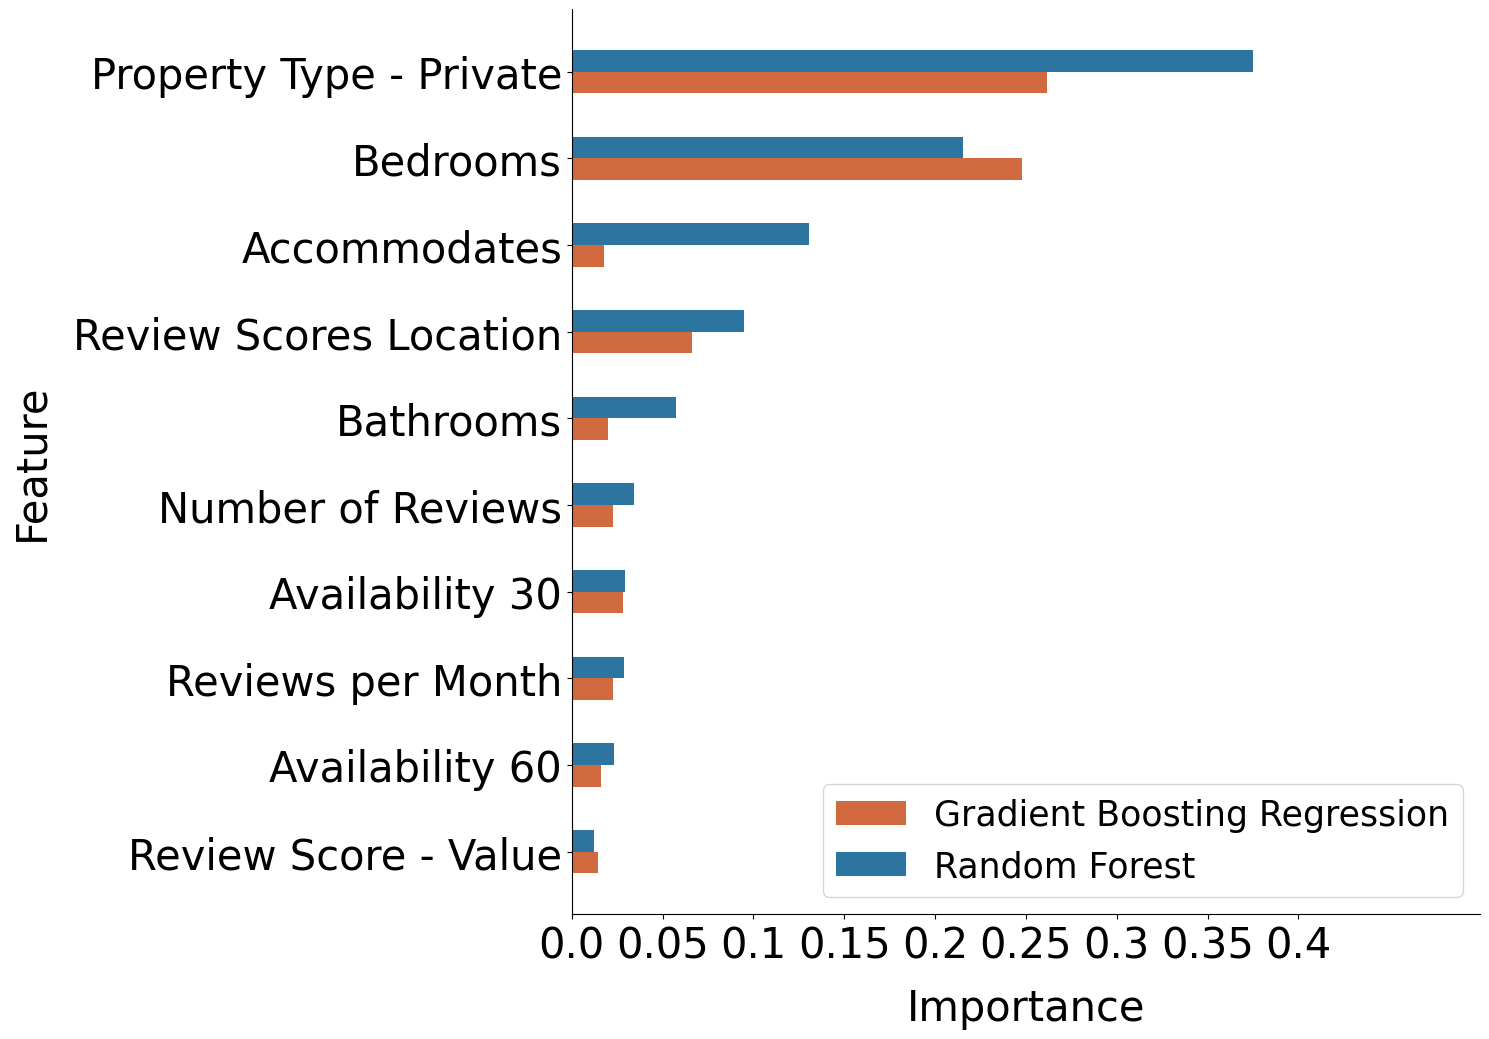

In [ ]:
# Shades of gray
GREY30 = "#4d4d4d"
GREY40 = "#474747"
GREY60 = "#999999"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

merged_df = pd.merge(top10Importances, importancesrf, on='Features').sort_values(by=['Importance_x'], ascending=False)
merged_df.index = ['Property Type - Private', 'Bedrooms', 'Accommodates', 'Review Scores Location', 'Bathrooms', 'Number of Reviews', 'Availability 30', 'Reviews per Month', 'Availability 60', 'Review Score - Value']

# display (merged_df)
# 2017 data
y2017 = merged_df.index.tolist()
x2017 = merged_df.Importance_x.tolist()

# 2018 data
y2018 = merged_df.index.tolist()
x2018 = merged_df.Importance_y.tolist()

# set width of bars
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(x2017))
r2 = [x + barWidth for x in r1]
    
fig, ax = plt.subplots(figsize=(15,10.5))

# Set title and labels
# ax.set_title('Feature Importances from Random Forest and Gradient Boosting Regression', fontweight='light', fontsize = 20, color=GREY30, x= 0.27, y=1.06)
ax.set_xlabel('Importance', fontsize=30)
ax.set_ylabel('Feature', fontsize = 30)

# Add padding
ax.yaxis.labelpad = 15
ax.xaxis.labelpad = 15

# Define sizes and rectangles
ind = np.arange(len(x2018))
width = 0.25

# Plot graphs
rects1 = ax.barh(ind + width, x2018, width, color='#d16a3e', label='Gradient Boosting Regression')
rects2 = ax.barh(ind, x2017, width, color='#2C75A0', label='Random Forest')

# Converts vlines to years and displays this as the tick labels
ax.set_xticks([0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], labels = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], fontsize = 30)
ax.set_yticks(ind +(width/2), labels = merged_df.index, fontsize = 30)

# Set limitis
ax.set_xlim(0,0.5)

# Customize spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Displays legend, sets tight layout and display graph
ax.legend(fontsize=25)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

#### Plotting Factors against Price to inspect relationships

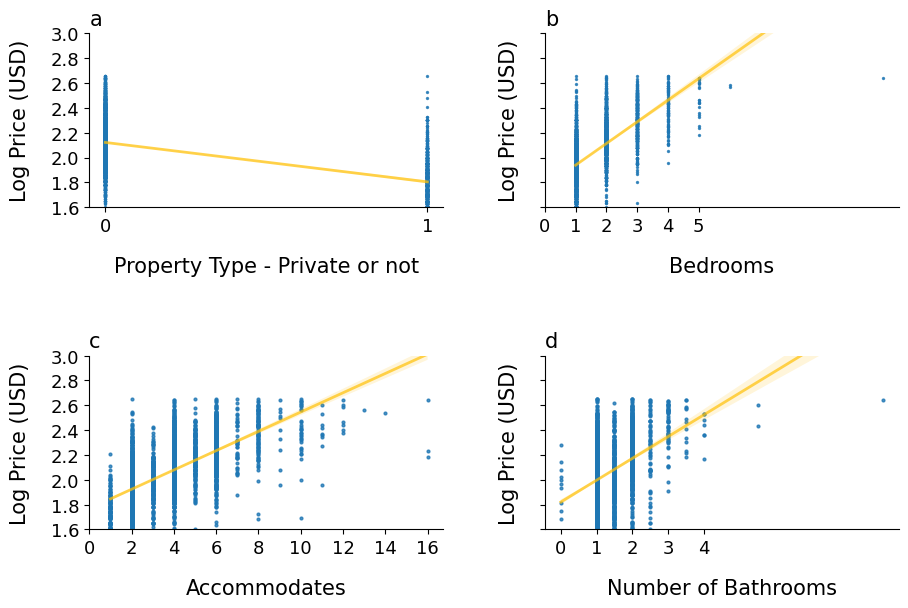

In [ ]:
# Shades of gray
GREY30 = "#4d4d4d"
GREY40 = "#474747"
GREY60 = "#999999"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

# GET DATA

# Plot figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,7), sharey='row')

# Plot 1
ax1.set_title("a", loc = "left", fontsize=15)
sns.regplot(x=dfDropped['property_type_Private'], y=dfDropped['price'], line_kws={"color":"#FFC107","alpha":0.7,"lw":2}, scatter_kws={'s':2}, ax=ax1)
ax1.set_xticks([0,1], labels = [0,1])
ax1.set_yticks([1.6,1.8,2.0,2.2,2.4,2.6,2.8, 3.0])
ax1.set_ylim(1.6,3)

# Labels and ticks
ax1.set_xlabel("Property Type - Private or not", fontsize = 15)
ax1.set_ylabel("Log Price (USD)", fontsize = 15)

# Plot 2
ax2.set_title("b", loc = "left", fontsize=15)
sns.regplot(x=dfDropped["bedrooms"], y=dfDropped["price"], line_kws={"color":"#FFC107","alpha":0.7,"lw":2}, scatter_kws={'s':2}, ax=ax2)
ax2.set_xticks([0,1,2,3,4,5], labels = [0,1,2,3,4,5])

# Labels and ticks
ax2.set_xlabel("Bedrooms", fontsize = 15)
ax2.set_ylabel("Log Price (USD)", fontsize = 15)

# Plot 3
# ax3.set_ylim(0,1.5)
ax3.set_title("c", loc = "left", fontsize=15)
sns.regplot(x=dfDropped["accommodates"], y=dfDropped["price"], line_kws={"color":"#FFC107","alpha":0.7,"lw":2}, scatter_kws={'s':4}, ax=ax3)
ax3.set_xticks([0,2,4,6,8,10,12,14,16], labels = [0,2,4,6,8,10,12,14,16])
ax3.set_yticks([1.6,1.8,2.0,2.2,2.4,2.6,2.8, 3.0])
ax3.set_ylim(1.6,3)

# Labels and ticks
ax3.set_xlabel("Accommodates", fontsize = 15)
ax3.set_ylabel("Log Price (USD)", fontsize = 15)

# Plot 4

# The horizontal plot is made using the hline function
sns.regplot(x=dfDropped["bathrooms_text"], y=dfDropped["price"], line_kws={"color":"#FFC107","alpha":0.7,"lw":2}, scatter_kws={'s':4}, ax=ax4)
ax4.set_xticks([0,1,2,3,4], labels=[0,1,2,3,4])

# Titles and labels
ax4.set_title("d", loc = "left", fontsize=15)
ax4.set_xlabel("Number of Bathrooms", fontsize = 15)
ax4.set_ylabel("Log Price (USD)", fontsize = 15)
         
# Customize spines: ax1
ax1.spines["right"].set_color("none")
ax1.spines["top"].set_color("none")

# Customize spines: ax2
ax2.spines["right"].set_color("none")
ax2.spines["top"].set_color("none")

# Customize spines: ax3
ax3.spines["right"].set_color("none")
ax3.spines["top"].set_color("none")

# Customize spines: ax4
ax4.spines["right"].set_color("none")
ax4.spines["top"].set_color("none")

#Padding
ax1.yaxis.labelpad = 15
ax1.xaxis.labelpad = 15

ax2.yaxis.labelpad = 15
ax2.xaxis.labelpad = 15

ax3.yaxis.labelpad = 15
ax3.xaxis.labelpad = 15

ax4.yaxis.labelpad = 15
ax4.xaxis.labelpad = 15

ax1.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax3.tick_params(axis='both', which='major', labelsize=13)
ax4.tick_params(axis='both', which='major', labelsize=13)

# Show the graph
fig.tight_layout(pad = 4.0)
plt.show()

<h5>Correlogram</h5>

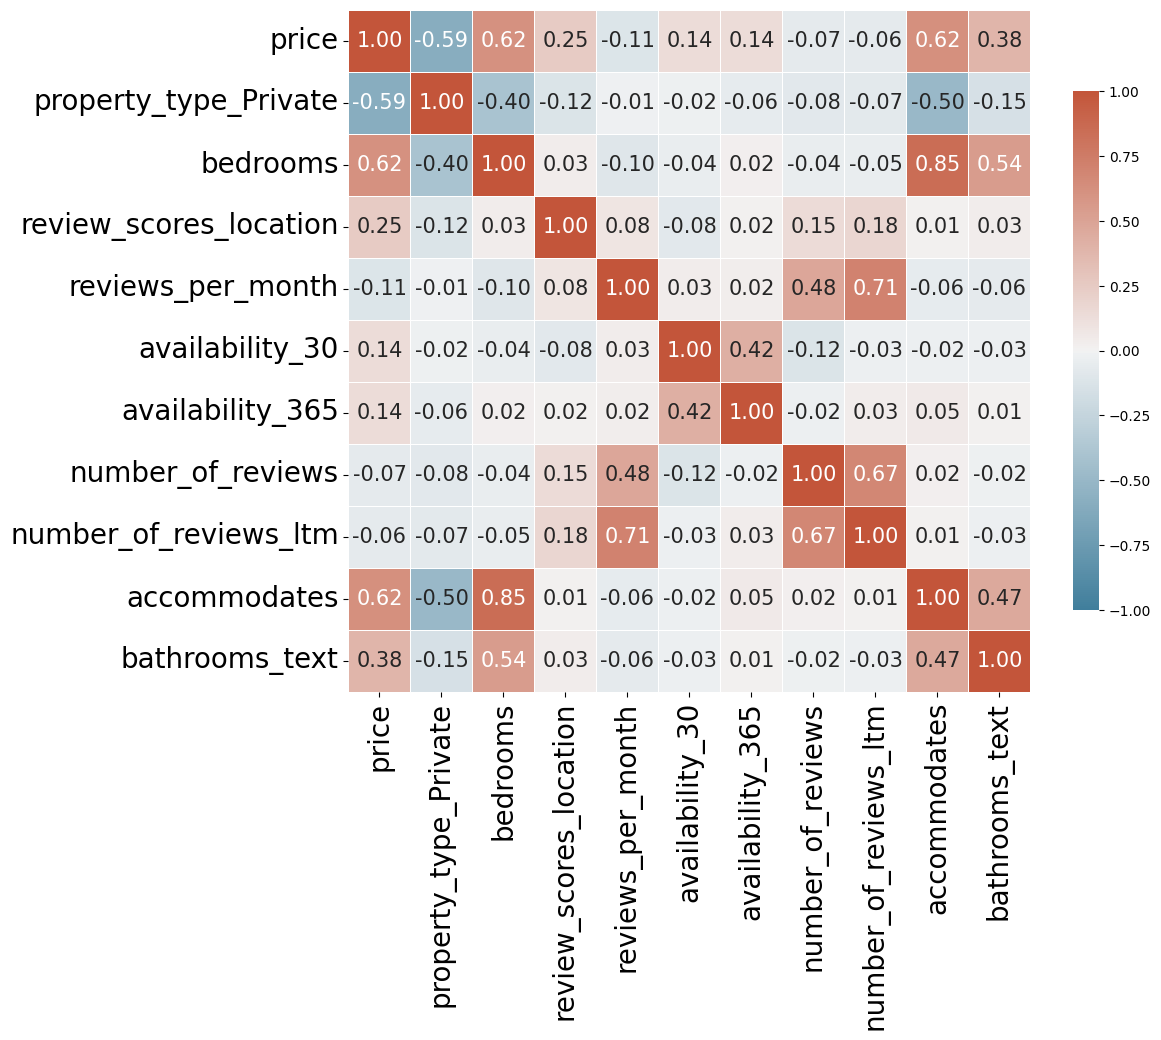

In [ ]:
# Basic correlogram

d = dfDropped[['price', 'property_type_Private', 'bedrooms', 'review_scores_location', 'reviews_per_month', 'availability_30', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'accommodates', 'bathrooms_text']]
corr = d.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# Draw the heatmap with annotations and correct aspect ratio
sns.heatmap(corr, cmap=cmap, annot=True, fmt='.2f', center=0, square=True, linewidths=.5, cbar_kws={"shrink": 0.75}, vmin=-1, vmax=1, annot_kws={"fontsize": 15})

# Change the font size of the tick labels
ax.tick_params(axis='both', which='major', labelsize=20)

In [ ]:
# http://data.insideairbnb.com/united-kingdom/scotland/edinburgh/2022-12-16/data/calendar.csv.gz

df = pd.read_csv('http://data.insideairbnb.com/united-kingdom/scotland/edinburgh/2022-12-16/data/calendar.csv.gz')

In [ ]:
df.dropna(inplace=True)

In [ ]:
# Converting price to float
df['price'] = df['price'].str.replace("$", "")
df['price'] = df['price'].str.replace(",", "")
df['price'] = df['price'].astype(float)

# Dropping prices not greater than 0
df = df[df.price > 0]

# Quartiles by the Empirical Rule
low = 0.025
high = 0.975
dfDropped1 = dfDropped.quantile([low, high])

# Empirical Rule
low = dfDropped1['price'][low]
high = dfDropped1['price'][high]

# Remove outliers in the dataframe to include only two standard deviations
dfDropped = dfDropped[dfDropped['price']>=low]
dfDropped = dfDropped[dfDropped['price']<=high]

df['date'] = pd.to_datetime(df['date'])

display(df)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,15420,2022-12-16,f,100.0,$100.00,3.0,30.0
1,15420,2022-12-17,f,115.0,$115.00,3.0,30.0
2,15420,2022-12-18,f,115.0,$115.00,3.0,30.0
3,15420,2022-12-19,f,115.0,$115.00,3.0,30.0
4,15420,2022-12-20,t,115.0,$115.00,3.0,30.0
...,...,...,...,...,...,...,...
2696631,389318,2023-12-11,t,44.0,$44.00,2.0,5.0
2696632,389318,2023-12-12,t,44.0,$44.00,2.0,5.0
2696633,389318,2023-12-13,t,44.0,$44.00,2.0,5.0
2696634,389318,2023-12-14,t,44.0,$44.00,2.0,5.0


In [ ]:
df1 = df.groupby(['date']).median()['price'].reset_index()
display(df1)

,date,price
0,2022-12-16,115.0
1,2022-12-17,120.0
2,2022-12-18,107.0
3,2022-12-19,108.0
4,2022-12-20,109.0
...,...,...
361,2023-12-12,120.0
362,2023-12-13,120.0
363,2023-12-14,120.0
364,2023-12-15,125.0


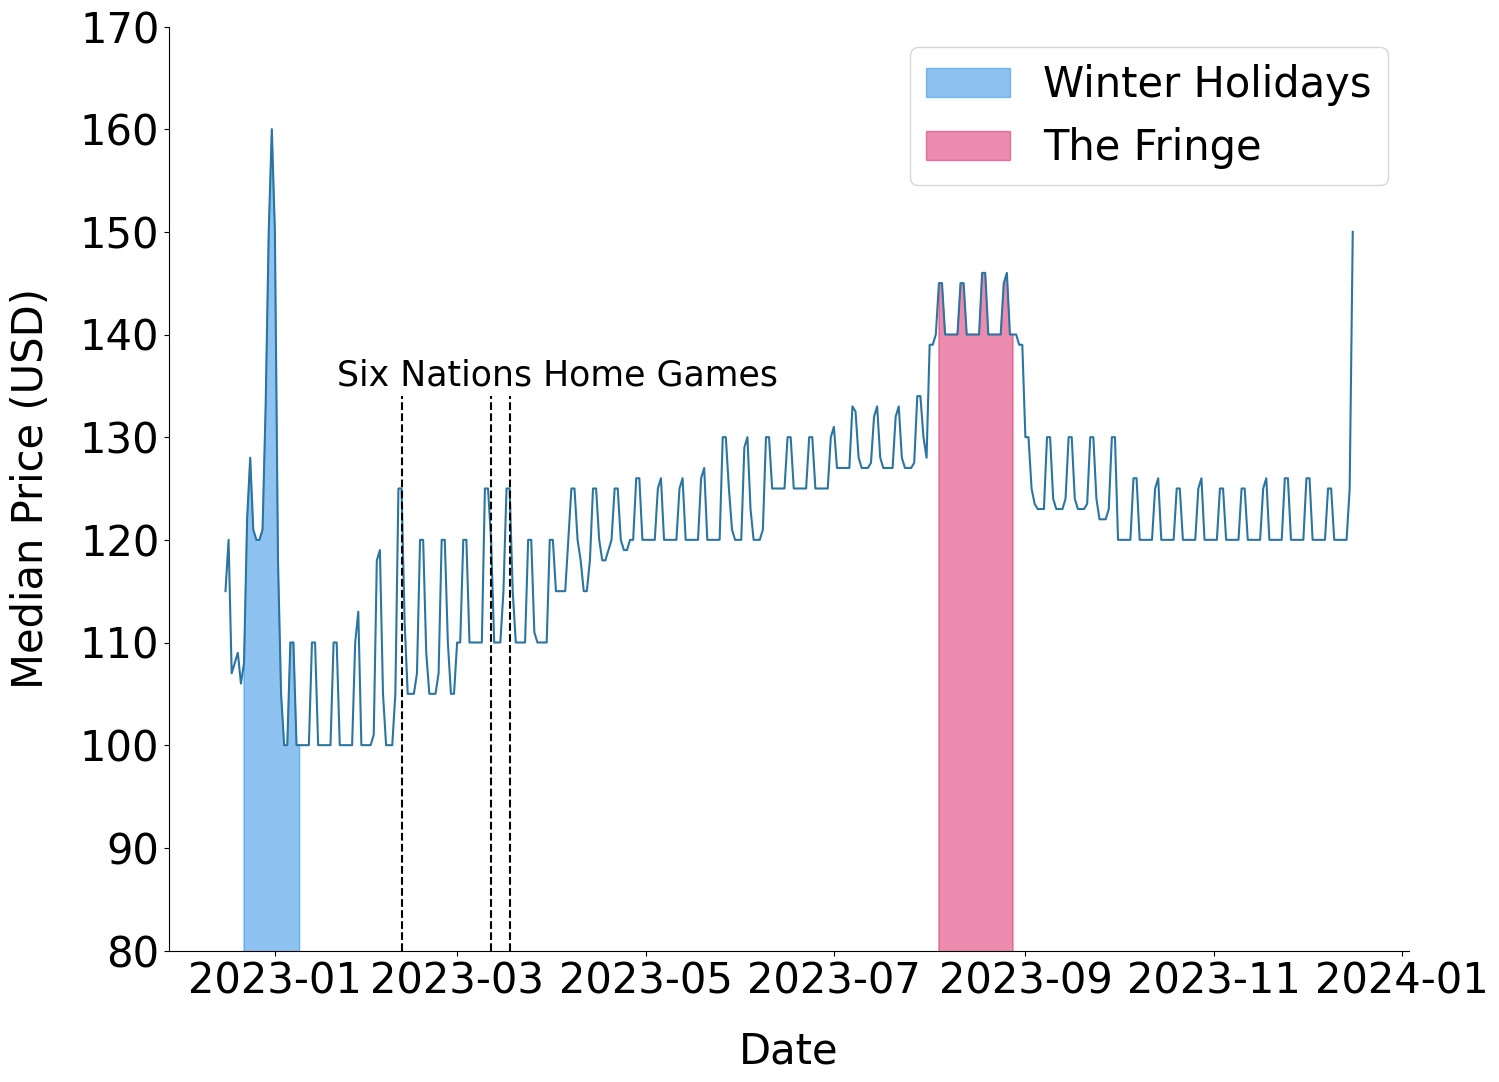

In [ ]:
# Shades of gray
GREY30 = "#4d4d4d"
GREY40 = "#474747"
GREY60 = "#999999"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

# Reads in date column and changes it to a datetime value
x1 = df1.date

# Reads in y values and applies a logarithmic transform using the natural log
y1 = df1.price

# Initialize layout 
fig, ax = plt.subplots(figsize = (16, 12))

# Plot data
ax.plot(x1, y1, color='#2C75A0')

# Set titles and labels
ax.set_xlabel('Date', fontsize = 30, labelpad=20)
ax.set_ylabel('Median Price (USD)', fontsize = 30, labelpad=20)

# Customize spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

ax.set_ylim(80, 170)

ax.fill_between(x1, 2, y1, where=(x1 >= '2022-12-22 00:00:00') & (x1 <= '2023-01-09 00:00:00'), alpha=0.5, label='Winter Holidays', color='#1E88E5')
ax.fill_between(x1, 2, y1, where=(x1 >= '2023-08-04 00:00:00') & (x1 <= '2023-08-28 00:00:00'), alpha=0.5, label='The Fringe', color='#D81B60')

ax.tick_params(axis='both', which='major', labelsize=30)

ax.axvline(x=np.datetime64('2023-02-11 00:00:00'), ymin=0, ymax=0.6, color='black', ls='dashed')
ax.axvline(x = np.datetime64('2023-03-12 00:00:00'), ymin=0, ymax=0.6, color='black', ls="dashed")
ax.axvline(np.datetime64('2023-03-18 00:00:00'), ymin=0, ymax=0.6, color='black', ls="dashed")

# Annotations indicating the meaning of the vertical line
ax.text(np.datetime64('2023-01-21 00:00:00'), 135, "Six Nations Home Games", 
        fontsize=25, fontweight=500, ha="left")

ax.legend(fontsize=30)

# Median for skewness

plt.show()

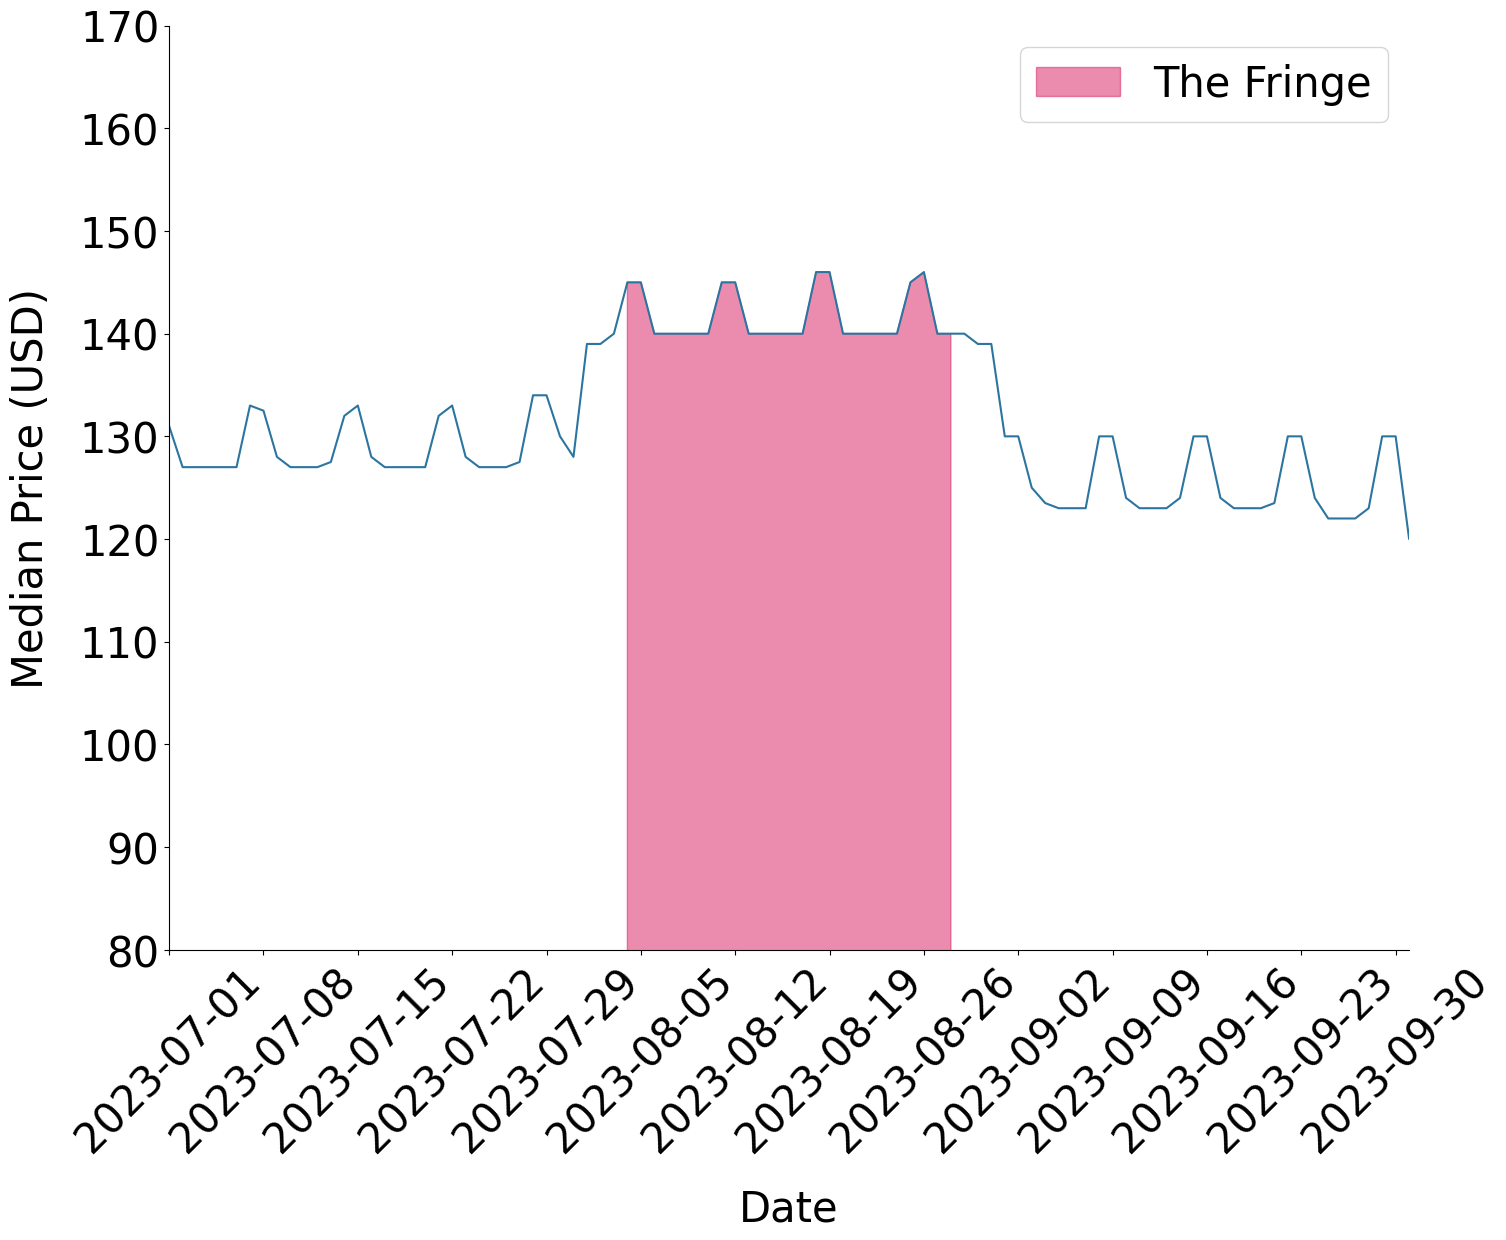

In [ ]:
# Remove outliers in the dataframe to include only two standard deviations

# Reads in date column and changes it to a datetime value
x1 = df1.date

# Reads in y values and applies a logarithmic transform using the natural log
y1 = df1.price

# Initialize layout 
fig, ax = plt.subplots(figsize = (16, 12))

# Plot data
ax.plot(x1, y1, color='#2C75A0')

# Set titles and labels
ax.set_xlabel('Date', fontsize = 30, labelpad=20)
ax.set_ylabel('Median Price (USD)', fontsize = 30, labelpad=20)

# Customize spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

ax.set_xlim(np.datetime64('2023-07-01 00:00:00'), np.datetime64('2023-10-01 00:00:00'))
ax.set_ylim(80, 170)

ax.set_xticks([np.datetime64('2023-07-01 00:00:00'), np.datetime64('2023-07-08 00:00:00'), np.datetime64('2023-07-15 00:00:00'), np.datetime64('2023-07-22 00:00:00'), np.datetime64('2023-07-29 00:00:00'), np.datetime64('2023-08-05 00:00:00'), np.datetime64('2023-08-12 00:00:00'), np.datetime64('2023-08-19 00:00:00'), np.datetime64('2023-08-26 00:00:00'), np.datetime64('2023-09-02 00:00:00'), np.datetime64('2023-09-09 00:00:00'), np.datetime64('2023-09-16 00:00:00'), np.datetime64('2023-09-23 00:00:00'), np.datetime64('2023-09-30 00:00:00')], labels=['2023-07-01', '2023-07-08', '2023-07-15', '2023-07-22', '2023-07-29', '2023-08-05', '2023-08-12', '2023-08-19', '2023-08-26', '2023-09-02', '2023-09-09', '2023-09-16', '2023-09-23', '2023-09-30'], rotation=45)

ax.tick_params(axis='both', which='major', labelsize=30)

ax.fill_between(x1, 2, y1, where=(x1 >= '2023-08-04 00:00:00') & (x1 <= '2023-08-28 00:00:00'), alpha=0.5, label='The Fringe', color='#D81B60')
ax.legend(fontsize=30)

plt.show()

In [ ]:
# Define the date range for the summer months
start_date = pd.to_datetime('2023-08-04 00:00:00')
end_date = pd.to_datetime('2023-08-28 00:00:00')

# Filter the data based on the date range
summer_data = df1[np.logical_and(df1['date'] >= start_date, df1['date'] <= end_date)]
non_summer_data = df1[np.logical_or(df1['date'] < start_date, df1['date'] > end_date)]

summer_mean = summer_data['price'].median()
non_summer_mean = non_summer_data['price'].median()

t_statistic, p_value = ttest_ind(summer_data['price'], non_summer_data['price'])

print('Summer median price:', summer_mean)
print('Non-summer median price:', non_summer_mean)
print('t-statistic:', t_statistic)
print('p-value:', p_value)

Summer mean price: 140.0
Non-summer mean price: 120.0
t-statistic: 11.472920481179942
p-value: 3.2201671628108785e-26
